# Quora Question pairs


Today it's a preparation for delivery 1.


The objective of today is to build a solution for:

https://www.kaggle.com/c/quora-question-pairs/overview

You might even make a late submission to kaggle to know how well you would have done in the competition.



In [1]:
import pandas as pd
import scipy
import sklearn
from sklearn import *
import numpy as np
import os

In [2]:
# use this to train and VALIDATE your solution
train_df = pd.read_csv("./quora_train_data.csv")

# use this to provide the expected generalization results
test_df = pd.read_csv("./quora_test_data.csv")

train_df

,id,qid1,qid2,question1,question2,is_duplicate
0,346692,38482,10706,Why do I get easily bored with everything?,Why do I get bored with things so quickly and ...,1
1,327668,454117,345117,How do I study for Honeywell company recruitment?,How do I study for Honeywell company recruitme...,1
2,272993,391373,391374,Which search engine algorithm is Quora using?,Why is Quora not using reliable search engine?,0
3,54070,82673,95496,How can I smartly cut myself?,Can someone who thinks about suicide for 7 yea...,0
4,46450,38384,72436,How do I see who is viewing my Instagram videos?,Can one tell who viewed my Instagram videos?,1
...,...,...,...,...,...,...
323427,192476,292119,292120,Is it okay to use a laptop while it is chargin...,Is it OK to use your phone while charging?,0
323428,17730,33641,33642,How can dogs understand human language?,Can dogs understand the human language?,0
323429,28030,52012,52013,What's your favourite lotion?,What's your favourite skin lotion?,1
323430,277869,397054,120852,How does one become a hedge fund manager?,What should I do to become a hedge fund manager?,1


In [3]:
A_df, te_df = sklearn.model_selection.train_test_split(train_df, test_size=0.05,random_state=123)

tr_df, va_df = sklearn.model_selection.train_test_split(A_df, test_size=0.05,random_state=123)

# Improving feature vectors:

Build a Similarity metric between documents using the tf-idf vectors of the documents.

Build a class from scratch that can learn a tf-idf feature representation.

In [4]:
from utils import TfIdfCustomVectorizer, TfIdfEmbeddingVectorizer, preprocess
from gensim.models import Word2Vec

First we are going to train a Word2Vec model, so that it better fits our problem.

In [5]:
all_questions = list(train_df["question1"]) + list(train_df["question2"])

In [6]:
w2v_model = Word2Vec(preprocess(all_questions), vector_size=256, window=5, min_count=1, workers=4)
w2v_model.save('word2vec_quora.model')

In [7]:
from utils import TfIdfEmbeddingVectorizer

vectorizer = TfIdfEmbeddingVectorizer().fit(all_questions)

X_train_q1 = vectorizer.transform(train_df['question1'])
X_train_q2 = vectorizer.transform(train_df['question2'])

In [123]:
def cosine(X, Y):
    norm = (np.linalg.norm(X, axis=1) * np.linalg.norm(Y, axis=1))
    return 1 - np.einsum('ij,ij->i', X, Y) / np.where(norm==0, 1, norm)

def manhattan(X, Y):
    return np.linalg.norm(X - Y, ord=1, axis=1)

def euclid(X, Y):
    return np.linalg.norm(X - Y, ord=2, axis=1)

X_train_dist_cos = cosine(X_train_q1, X_train_q2)
X_train_dist_man = manhattan(X_train_q1, X_train_q2)
X_train_dist_euc = euclid(X_train_q1, X_train_q2)

In [124]:
from matplotlib import pyplot as plt

def tpr_fpr(p, dist, y_true):
    accurate = y_true == (dist < p)
    tpr = accurate[y_true == 1].mean()
    fpr = 1 - accurate[y_true == 0].mean()
    return tpr, fpr

y = train_df['is_duplicate'].to_numpy()
roc_cos = [tpr_fpr(p, X_train_dist_cos, y) for p in np.linspace(0, 1, 1000)]
roc_man = [tpr_fpr(p, X_train_dist_man, y) for p in np.linspace(0, X_train_dist_man.max(), 1000)]
roc_euc = [tpr_fpr(p, X_train_dist_euc, y) for p in np.linspace(0, X_train_dist_euc.max(), 1000)]

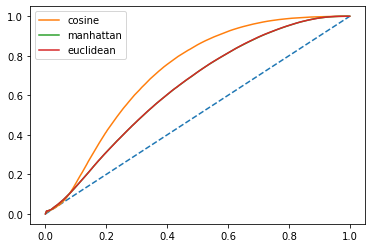

In [126]:
plt.plot([0,1],[0,1], '--')

tpr, fpr = zip(*roc_cos)
plt.plot(fpr, tpr, label='cosine')

tpr, fpr = zip(*roc_man)
plt.plot(fpr, tpr, label='manhattan')

tpr, fpr = zip(*roc_euc)
plt.plot(fpr, tpr, label='euclidean')

plt.legend()

In [127]:
y, x = zip(*roc_cos)
metrics.auc(x, y)

0.7114822057946505

In [29]:
print(metrics.classification_report(test_df['is_duplicate'],y_hat))

NameError: name 'y_hat' is not defined